## 0) Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [4]:
# Importing the clean dataset
clean_credit_card_df = pd.read_csv('Dataset/cleaned_credit_card_data.csv')

## 1) Data Preprocessing

The dataset contains many columns that useless for classificaton purposes, such as identifiers, names and other non-informative features that are only useful for human interpretation. We will remove these columns to reduce the dimensionality of the dataset and improve the performance of our model. In particular, we decided to drop the following columns:
- `ID`: unique identifier for each record
- `Name`: name of the individual
- `SSN`: social security number
- `Customer_ID`: unique identifier for each customer
- `Month`: month of the year in which the record was created

Also, since the column `Stree` alone cannot be informative, and if combined with `City` becomes a categorical variable with too many unique values, we will drop it as well. In addition, a sensitive classification model that predicts credit score should not be bised by where the individual lives. We will get to the `City` column later, and for now we limit ourselves to dropping the `Street` column.


In [6]:
# Drop useless columns (identifiers, etc.)
columns_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']
if columns_to_drop[0] in clean_credit_card_df.columns:
    clean_credit_card_df.drop(columns=columns_to_drop, inplace=True)

# Drop Street columns if they exist
if 'Street' in clean_credit_card_df.columns:
    clean_credit_card_df.drop(columns=['Street'], inplace=True)

Up to now, this is the dataset that is going to be used for the classification task. As a consequence, we can store it in a csv file and use it for the rest of the notebook.

In [7]:
# Store the cleaned dataset in a new CSV file
clean_credit_card_df.to_csv('Dataset/model_credit_card_data.csv', index=False)

## 2) Data Visualization

Although we've completed some initial preprocessing, that was only a basic first step. Further preprocessing is necessary to prepare the data effectively for training a machine learning model. Data visualization plays a crucial role in this phase it helps us gain deeper insights into the data, spot potential issues, and uncover meaningful patterns or trends. For example, visualizing the distribution of the target variable or examining correlations between features and the target can guide our modeling decisions and improve performance.

### 2.1) Target Variable Distribution
We will start by visualizing the distribution of the target variable, `Credit_Score`, to understand its characteristics. This will help us determine if the data is balanced or imbalanced, which can influence our choice of evaluation metrics and modeling techniques. We will also check for any anomalies in the target variable that may need to be addressed.

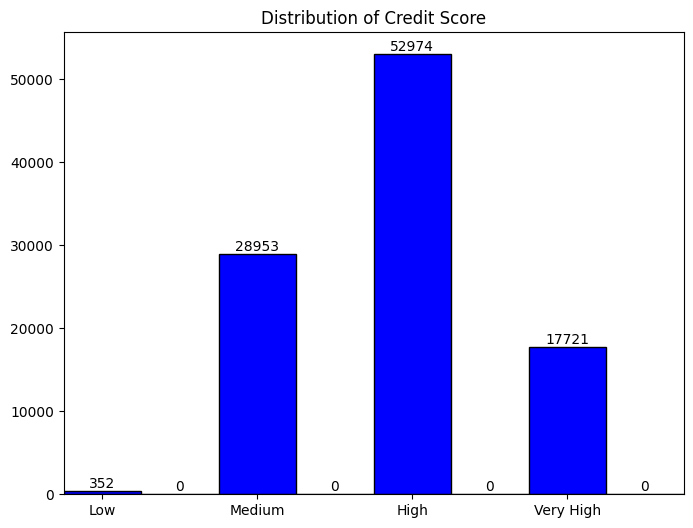

In [8]:
# Show the distribution of the target variable with an histogram
bins = np.arange(0, 4.5, 0.5)
target_variable = clean_credit_card_df['Credit_Score']

plt.figure(figsize=(8, 6))
plt.hist(target_variable, bins=bins, color='blue', alpha=1.0, edgecolor='black')
plt.title('Distribution of Credit Score')
plt.xticks([0.25, 1.25, 2.25, 3.25], ['Low', 'Medium', 'High', 'Very High'])
plt.xlim(0, 4)
# Add the number of observations on top of each bar
for i in range(len(bins)-1):
    plt.text(bins[i] + 0.25, target_variable[(target_variable >= bins[i]) & (target_variable < bins[i+1])].count() + 0.5,
             str(target_variable[(target_variable >= bins[i]) & (target_variable < bins[i+1])].count()),
             ha='center', va='bottom', fontsize=10, color='black')
plt.show()

The bar chart above displays the distribution of the `Credit Score` target variable across four categories: **Low**, **Medium**, **High**, and **Very High**. From the visualization, it's clear that:
- The **High** category (52974) is the most frequent, indicating that the dataset is heavily skewed toward individuals with high credit scores.
- The **Medium** (28953) and **Very High** (17721) categories follow, with **Medium** having a considerably larger count.
- The **Low** category is extremely underrepresented, with very few instances, only 352, which represents less than 0.5% of the total dataset.

This imbalance may lead to biased model predictions, as most algorithms assume an even distribution of classes. To address this, we will need to apply techniques to balance the dataset, such as oversampling the minority class or undersampling the majority class.

### 2.1) Numerical Features Distribution

We will now visualize the distribution of the numerical features in the dataset. This will help us understand the range and distribution of values for each feature, identify any potential outliers, and assess whether any transformations or scaling are needed before training our model.

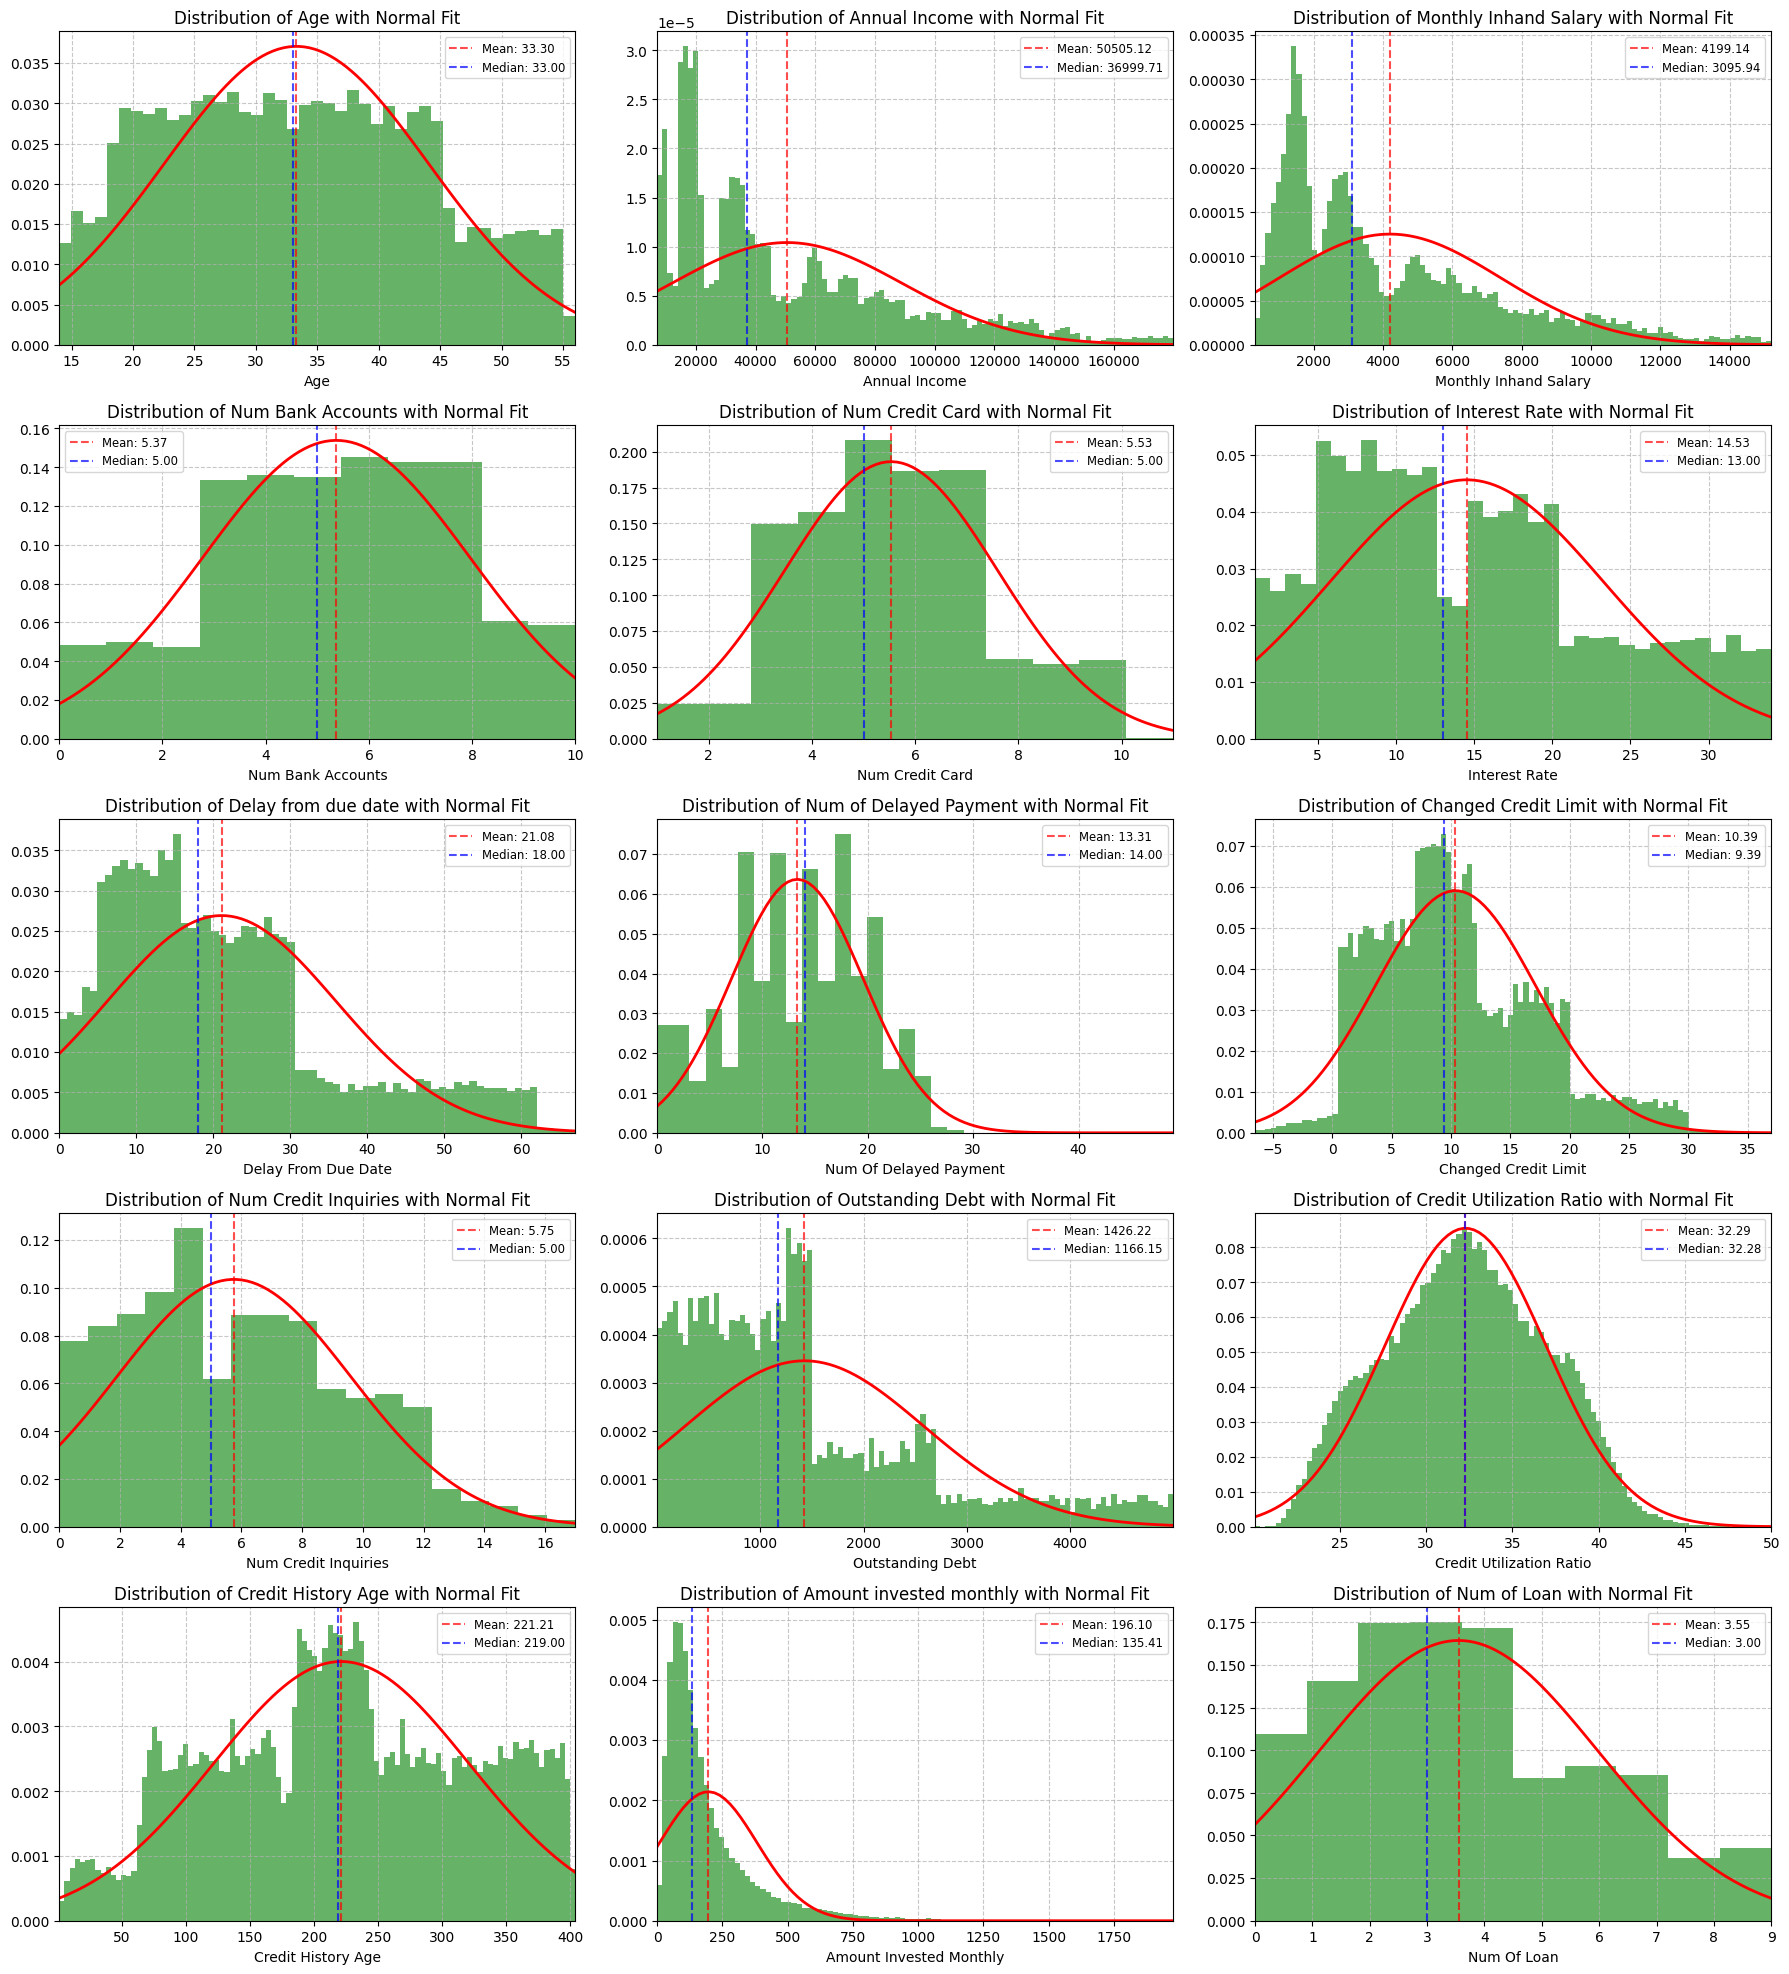

In [9]:
# Get the list of numerical feature names from the cleaned dataframe.
numeric_features = clean_credit_card_df.select_dtypes(include=['number']).columns

# Exclude the target variable and all the columns that are used to store the type of loan
loans_columns = ['Not Specified', 'Mortgage Loan', 'Payday Loan', 'Home Equity Loan', 'Credit-Builder Loan', 'Student Loan', 'Debt Consolidation Loan',
                  'Personal Loan', 'Auto Loan']
columns_to_drop = ['Credit_Score'] + loans_columns
numeric_features = numeric_features.drop(columns_to_drop, errors='ignore')

# Store the number of features to plot
n_features = len(numeric_features)

# Define grid size
n_cols = 3  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate required number of rows

# Create subplots with a grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through all numerical features and plot their distributions
for i, col in enumerate(numeric_features):
    ax = axes[i]
    data = clean_credit_card_df[col]
    
    # Plot histogram with density normalization
    n_bins = 0
    ax.hist(data, bins = min(len(data.unique()), 100), density=True, alpha=0.6, color='green')
    ax.set_xlim(data.min(), data.max())  # Set x-axis limits to focus on the range of interest
    
    # Fit a normal distribution to the data and plot it
    mu, std = norm.fit(data)
    x = np.linspace(data.min(), data.max(), 100)
    y = norm.pdf(x, mu, std)
    ax.plot(x, y, 'r-', lw=2)
    
    # Add vertical lines for mean and median
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='blue', linestyle='--', alpha=0.7, label=f'Median: {median_val:.2f}')
    
    # Add legend, grid, and style ticks
    ax.legend(fontsize='small')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Set titles and labels
    ax.set_title(f'Distribution of {str(col).replace("_", " ")} with Normal Fit')
    ax.set_xlabel(str(col).replace('_', ' ').title())

# Remove any unused subplots if n_features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The plots above show the distributions of several numerical features in the dataset, overlaid with a normal (Gaussian) distribution for reference. Here are some key observations:

- **Normality**: Most variables deviate from a normal distribution, as evident by the skewed shapes of many histograms compared to the red normal fit curve.
  - Features like **Num_Bank_Accounts**, **Num_Credit_Card**, and **Credit_Utilization_Ratio** are fairly close to normal.
  - Others, such as **Annual_Income**, **Monthly_Inhand_Salary**, and **Amount_invested_monthly**, are **right-skewed**, indicating the presence of high-income outliers or a concentration of lower values.
  
- **Central Tendency**: Each plot includes the **mean** and **median**, which help illustrate the skewness:
  - In right-skewed distributions (e.g., **Annual_Income**, **Outstanding_Debt**), the **mean > median**, a common trait of positively skewed data.
  - For more symmetric distributions (e.g., **Credit_Utilization_Ratio**), the mean and median are close.

- **Outliers**: Several variables show long tails or sharp spikes that may indicate **potential outliers**—especially in features like **Num_Credit_Inquiries**, **Changed_Credit_Limit**, and **Delay_from_due_date**.

Overall, this visualization helps identify which features may need **normalization or transformation** (e.g., log scaling) before being used in a model. Additionally, skewed distributions might affect model performance and could be addressed depending on the algorithm used.

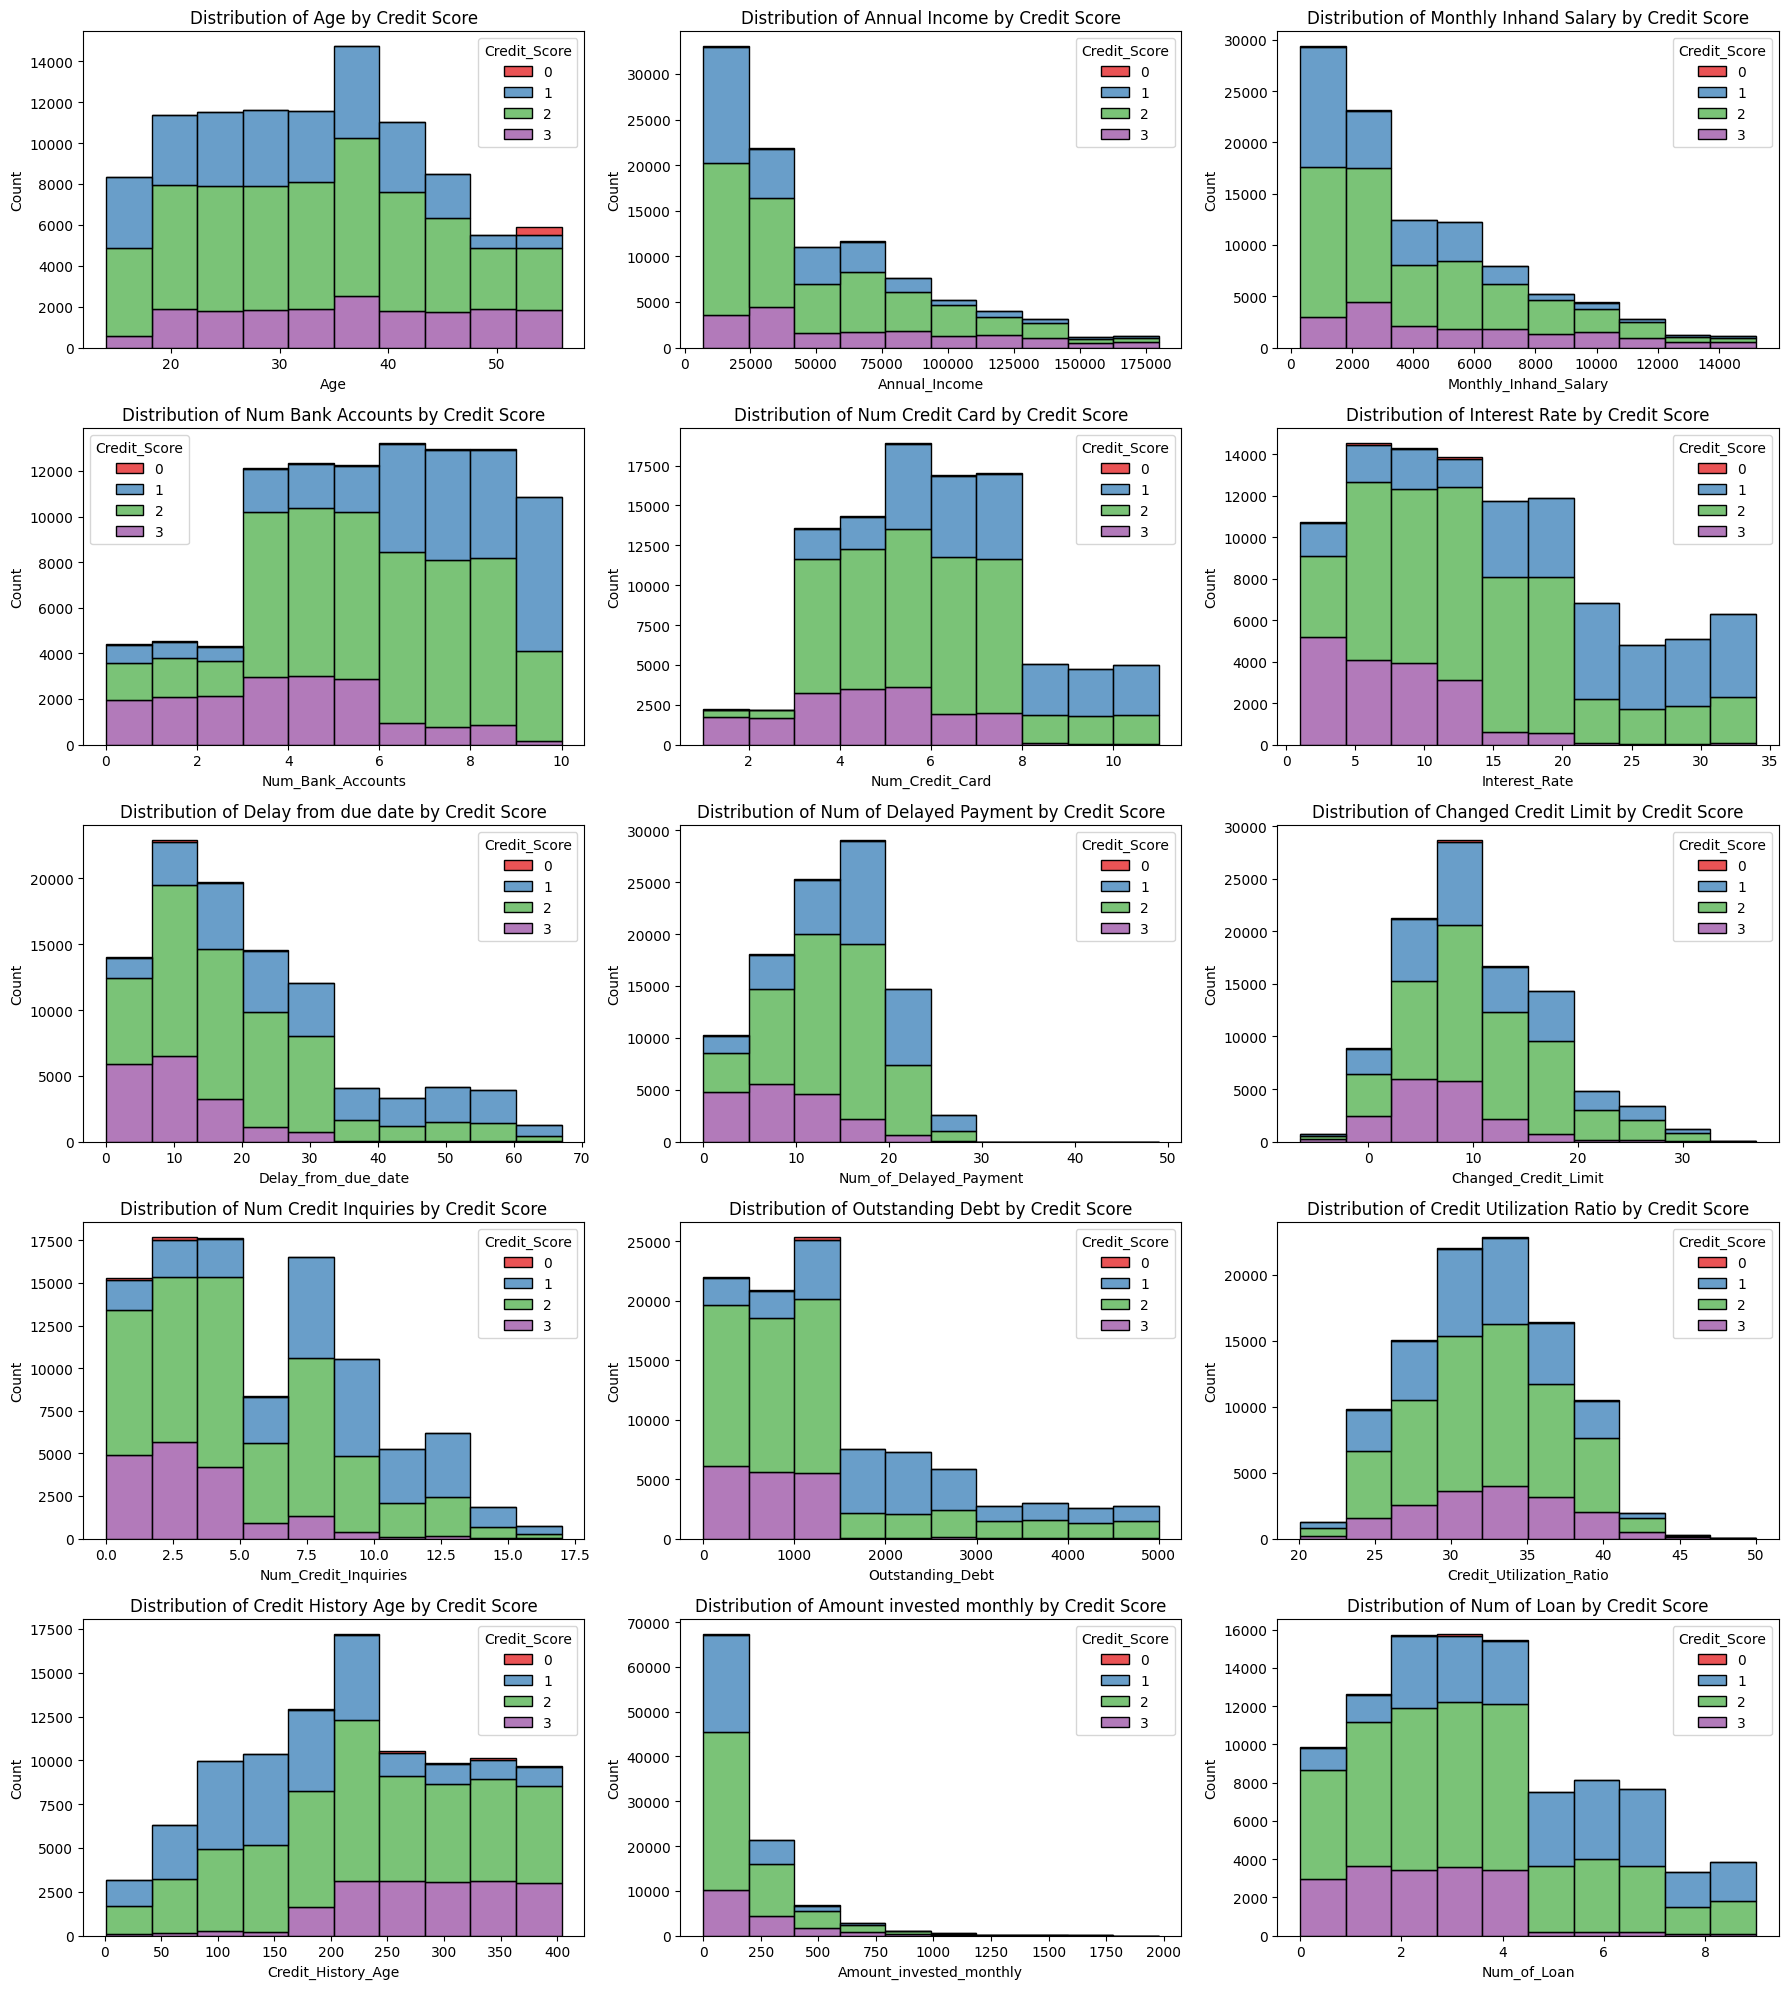

In [10]:
# Create subplots with a grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing


for i, col in enumerate(numeric_features):
    ax = axes[i]
    sns.histplot(data = clean_credit_card_df, x=col, hue = target_variable, multiple="stack", palette="Set1", bins= min(len(data.unique()), 30), ax=ax)
    ax.set_title(f'Distribution of {str(col).replace("_", " ")} by Credit Score')

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The above visualizations help identify how different credit score levels relate to various financial and behavioral features. By analyzing these relationships, we can gain insights into the factors influencing credit scores and potentially improve our model's performance. Here are some key observations from the visualizations:

1) The `Age` distribution is concentrated between 20 and 40 years, with most individuals scoring a 2. Credit score 3 (likely the lowest) appears infrequently across all ages, especially under 30. There's no strong age-based separation, suggesting age alone may not determine credit score. However, this is the only feature in whihc it is possible to distinguish the **Low** category from the others, indicating that older individuals tend to be associated with the latter. 

2) `Annual income` is highly right-skewed, with most individuals earning under $50,000. Higher scores (2 and 3) are more common in higher income brackets, while the worst scores (1) are more prevalent at lower incomes. This suggests a **positive correlation** between income and credit score.

3) `Monthly Inhand Salary `is similar to Annual Income, this variable is also skewed. Categories 2 and 3 dominate across all ranges, but especially above $3000/month. Low in-hand salaries are more frequently associated with score 0, reinforcing that disposable income may be a useful predictor.

4) `Num Bank Accounts`: most people have between 2 and 7 bank accounts. Higher scores (2 and 3) are more frequent in this range, while very low or very high account counts show a slightly higher proportion of poor scores (0). A balanced number of bank accounts appears more favorable.

5) `Num Credit Card`: Individuals with 3 to 8 credit cards are most common, with high scores (3) peaking in that range. Too few or too many credit cards (especially >10) show higher instances of score 0. Moderate credit card ownership may be associated with responsible credit use.

6) `Interest Rate` vary widely, but high interest rates (above 20%) are more likely associated with score 0. Lower interest rates (below 10%) are mostly tied to scores 2 and 3. This likely reflects lenders assigning lower rates to more creditworthy individuals.

7) `Delay from due date`: Most delays are under 25 days. Individuals with fewer days delayed tend to have higher scores, especially 3. As delay increases, score 0 becomes more frequent. This shows that **late payments significantly reduce credit score**.

8) `Num of Delayed Payment`: There’s a large spike at 0 delayed payments, which is heavily associated with score 3. As the number of delayed payments increases, the proportion of score 0 rises sharply. This is a **strong indicator** of credit risk.

9) `Changed Credit Limit`: Most people have a moderate change in credit limit (5–15). Scores 2 and 3 dominate here, but large changes (especially above 20) appear more with lower scores. This might reflect reactive credit changes following poor behavior.

10) `Num Credit Inquiries`: Fewer inquiries (0–5) are clearly associated with high scores (2 and 3), while a higher number of inquiries (10+) correlate with score 0. This supports the idea that **excessive credit seeking is a negative signal**.

11)  `Outstanding Debt`: Debt is highly skewed. Individuals with lower outstanding debt tend to have better scores. As debt increases beyond 2000, score 0 becomes more prevalent. **Higher debt burden appears to be a risk factor**.

12)  `Credit Utilization Ratio`: This is one of the most telling features. Scores 3 and 2 cluster around utilization rates of 25–35%, while scores 0 increase with higher utilization (above 40%). **Lower utilization aligns with better creditworthiness**, as expected.

13)  `Credit History Age`: A longer credit history (150–300) corresponds to higher scores. Shorter histories (under 100) see more score 0 entries. This follows the expected pattern where longer credit history suggests greater reliability.

14)  `Amount invested monthly`: This feature is skewed right. Higher credit scores (2 and 3) are more common among those who invest regularly, especially above $300/month. Individuals with no or very low investments are more likely to have poor scores, suggesting that **financial planning behavior contributes positively to creditworthiness**.


**Summary**:  
The most informative features for separating credit score categories appear to be:
- `Num of Delayed Payment`
- `Delay from due date`
- `Credit Utilization Ratio`
- `Num Credit Inquiries`
- `Amount invested monthly`

These behaviors closely reflect typical financial risk factors used in real-world credit scoring.

### 2.2) Categorical Features Distribution

We will now visualize the distribution of the categorical features in the dataset. This will help us understand how different categories relate to the target variable and identify any potential issues with the data.

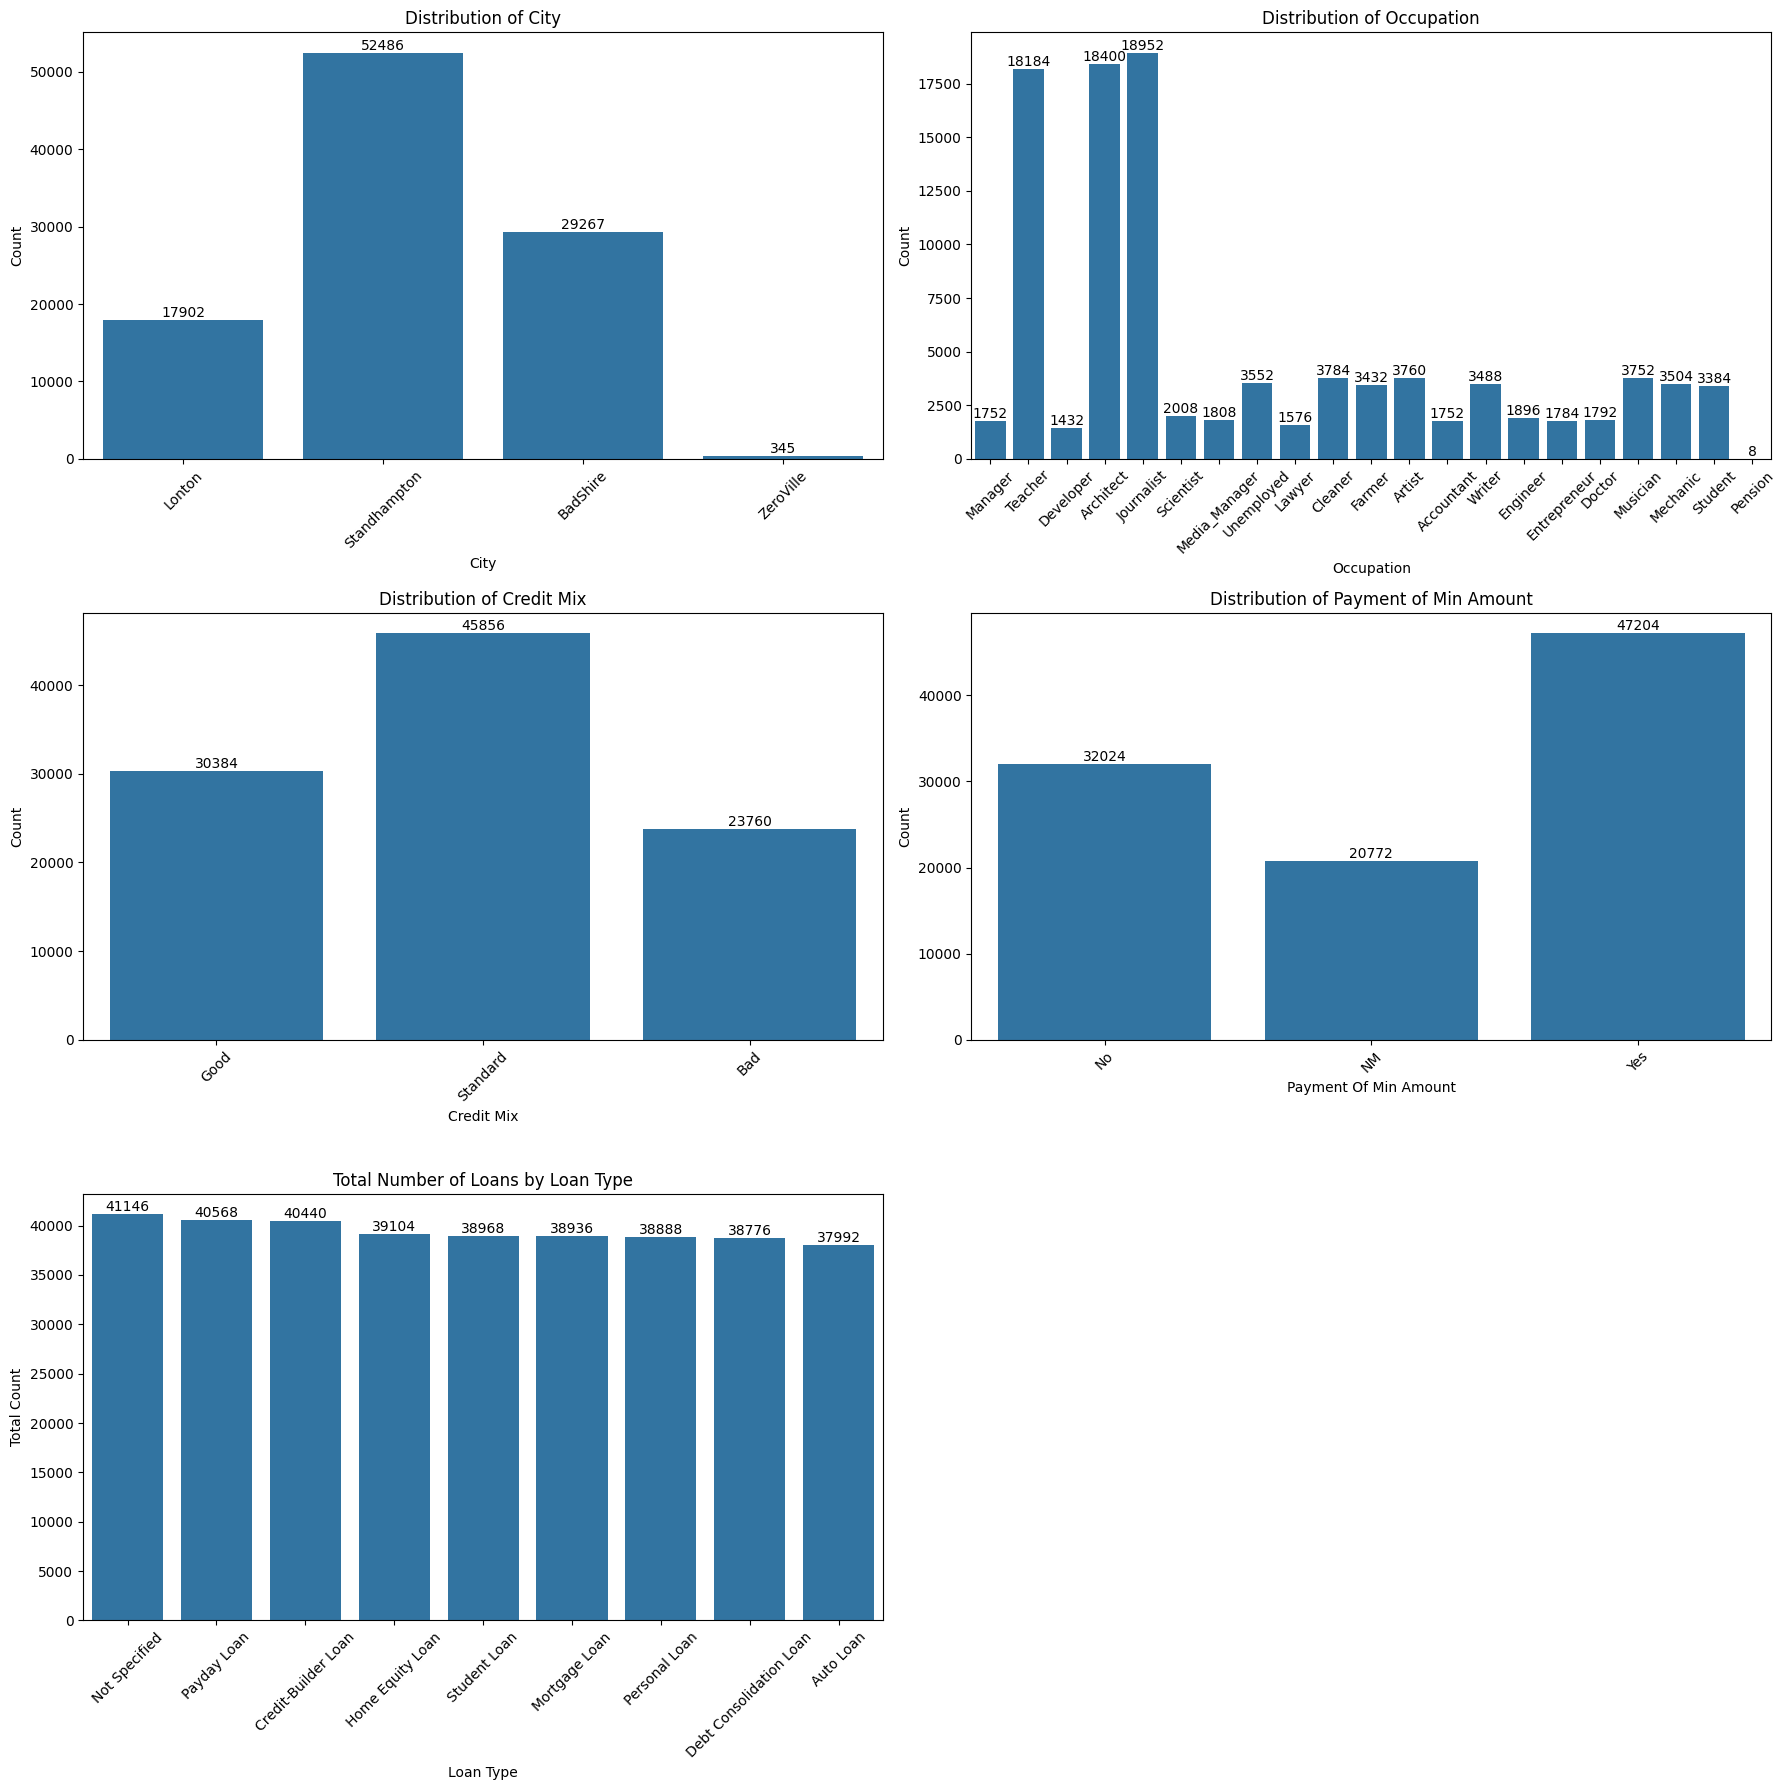

In [19]:
categorical_features = clean_credit_card_df.select_dtypes(include=['object']).columns

# Plot the distribution of categorical features
n_features = len(categorical_features)

# Define grid size
n_cols = 2  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols + 1 # Calculate required number of rows

# Create subplots with a grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()

# Plot categorical feature distributions
for i, col in enumerate(categorical_features):
    ax = axes[i]
    sns.countplot(data=clean_credit_card_df, x=col, ax=ax)
    ax.set_title(f'Distribution of {str(col).replace("_", " ")}')
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black')

# Plot loan type distribution in the next subplot
loan_columns = ['Not Specified', 'Mortgage Loan', 'Payday Loan', 'Home Equity Loan',
                'Credit-Builder Loan', 'Student Loan', 'Debt Consolidation Loan',
                'Personal Loan', 'Auto Loan']

loan_totals = clean_credit_card_df[loan_columns].sum().sort_values(ascending=False)

loan_ax_index = i + 1
if loan_ax_index < len(axes):
    ax = axes[loan_ax_index]
    sns.barplot(x=loan_totals.index, y=loan_totals.values, ax=ax)
    for bar, value in zip(ax.patches, loan_totals.values):
        ax.annotate(f'{int(value)}', (bar.get_x() + bar.get_width() / 2., value),
                    ha='center', va='bottom', fontsize=10, color='black')
    ax.set_title('Total Number of Loans by Loan Type')
    ax.set_xlabel('Loan Type')
    ax.set_ylabel('Total Count')
    ax.tick_params(axis='x', rotation=45)

# Remove unused subplots (if any)
for j in range(i + 2, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Categorical Feature Distributions

1) `City`: The majority of customers are from **Standhampton**, followed by **Badshire** and **Lonton**. **Zeroville** has a very small representation (345 records), which might make it less impactful or even a candidate for grouping as "Other" during preprocessing.

2) `Occupation`: the distribution of occupations is fairly spread out, with **Journalist**, **Architect**, and **Teacher** having the highest counts. Categories like **Pension**, **Unemployed**, and **Scientist** have very few entries and might be considered rare categories. These might need to be grouped or one-hot encoded carefully to avoid sparsity.

3) `Credit Mix`: is the most common credit mix, followed by **Good** and then **Bad**. This implies most individuals are categorized as having a moderate credit mix, which may indicate balanced or average financial behavior.

4) `Payment of Minimum Amount`: Most people do pay the minimum amount ("Yes"), followed by "No", and then "NM". This variable could be highly indicative of credit responsibility, especially distinguishing between "Yes" and "No" groups.

5) `Loan Type`: shows that almost all types of loans occur in the dataset with the same frequency. 


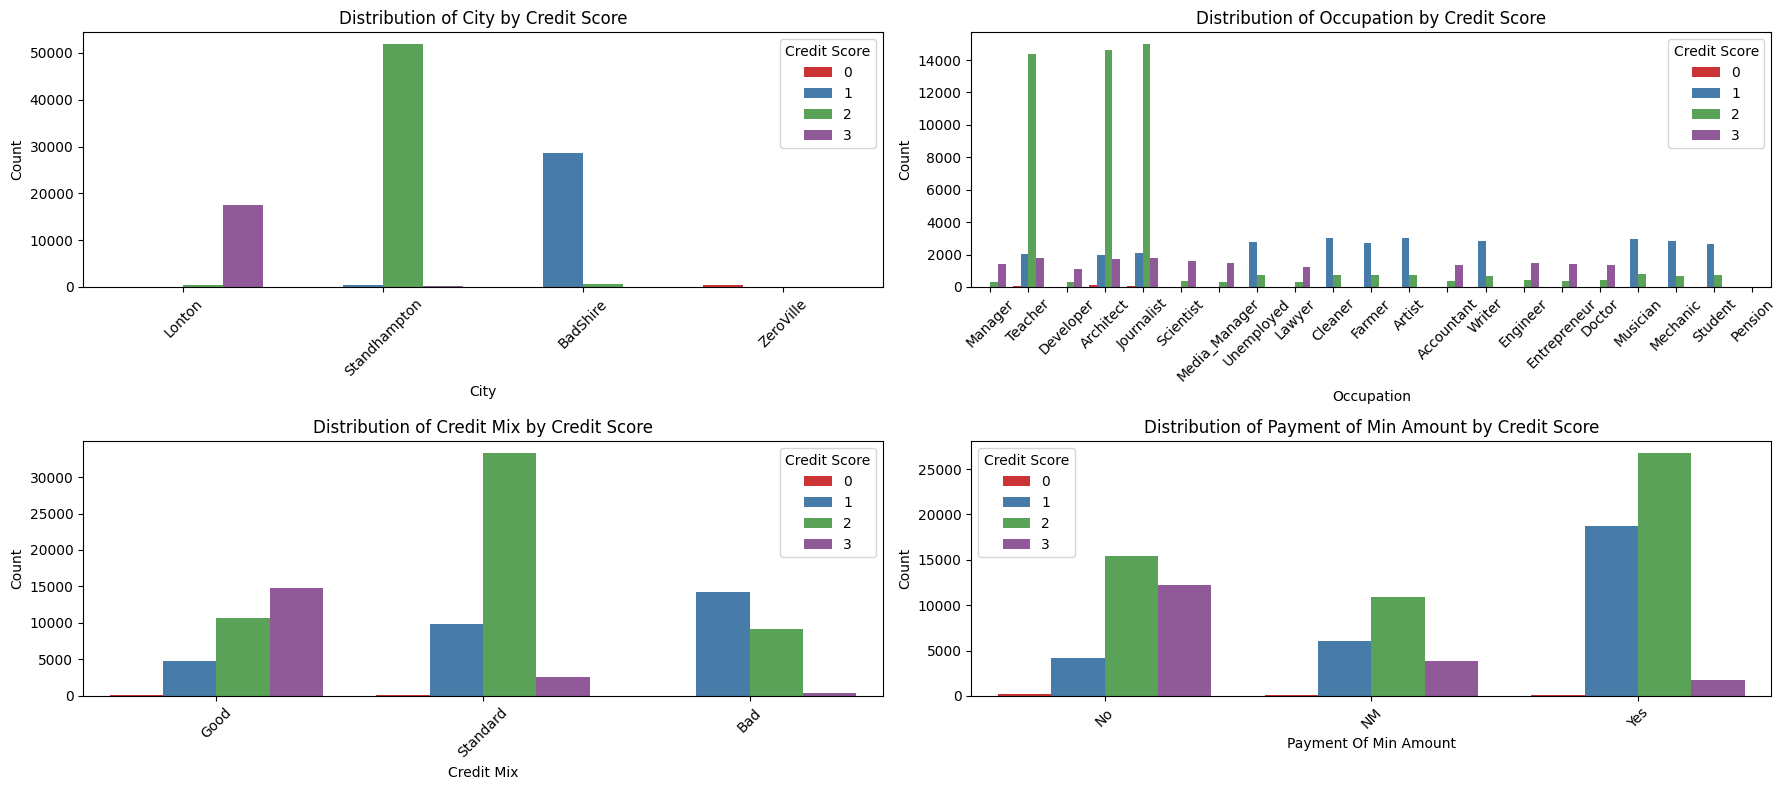

In [20]:
# Plot the distribution of categorical features by target (Credit_Score)
n_features = len(categorical_features)
n_cols = 2  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    ax = axes[i]
    sns.countplot(data=clean_credit_card_df, x=col, hue='Credit_Score', ax=ax, palette="Set1")
    ax.set_title(f'Distribution of {col.replace("_", " ")} by Credit Score')
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Credit Score')

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Observations on Categorical Feature Distributions by Credit Score

The distribution of `Credit_Score` across different cities reveals a **strong and likely problematic pattern**: nearly everyone in a given city has the same credit score. For example:
- Almost all residents of **Standhampton** have a `Credit_Score` of 2.
- In **Lonton**, nearly all records belong to category 3.
- **Badshire** mostly maps to score 1.
- **Zeroville** has very few observations but appears tied to score 0.

This suggests that `City` might be acting as a **proxy for the target variable**, introducing both **data leakage** and **bias** into the model. Including such a feature in training could:
- Lead to **artificially high accuracy** during evaluation,
- Mask the model's inability to generalize,
- And reinforce misleading patterns that don’t reflect real-world behavior.

From a **fairness and ethics perspective**, this is also highly problematic. A person’s **city of residence should not be a determinant of their creditworthiness**. If a model learns to make predictions based on geography in this way, it risks **encoding geographic or socioeconomic bias** — penalizing individuals just because they live in a certain location.

We did not identify any other relevant issues related to categorical features.

## 3) Correlation Analysis

We will now visualize the correlation between the features in the dataset. This will help us understand how different features relate to each other and identify any potential issues with multicollinearity. We will also check for any potential interactions between features that may be useful for modeling. It is also important to have an initial understanding of the relationships between features and the target variable, as this can help us identify which features are most important for classification.

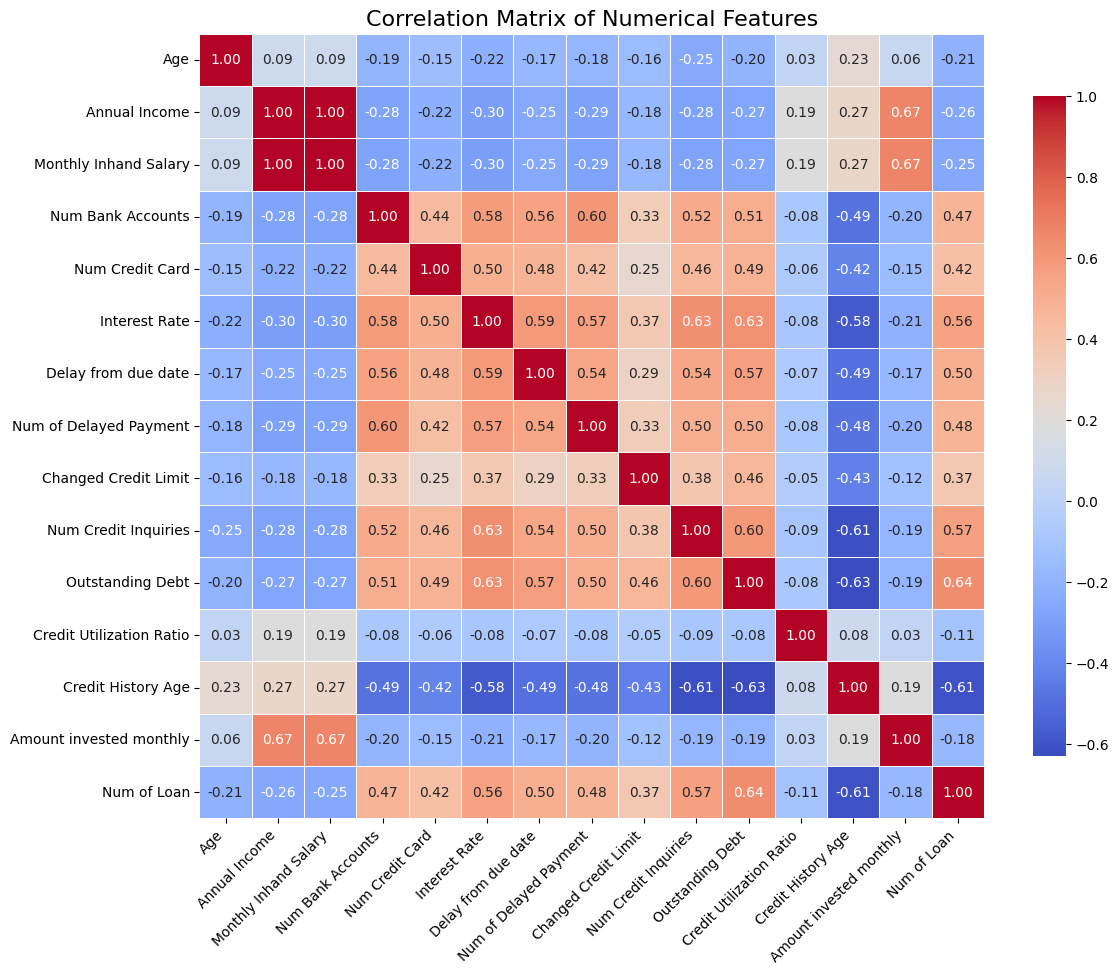

In [21]:
# Compute the correlation matrix considering only numerical features
correlation_matrix = clean_credit_card_df[numeric_features].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

# Adjust ticks to be at the center of the squares
plt.xticks(ticks=np.arange(len(correlation_matrix.columns)) + 0.5, 
           labels=[col.replace('_', ' ') for col in correlation_matrix.columns], 
           rotation=45, ha='right', fontsize=10)
plt.yticks(ticks=np.arange(len(correlation_matrix.index)) + 0.5, 
           labels=[col.replace('_', ' ') for col in correlation_matrix.index], 
           rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


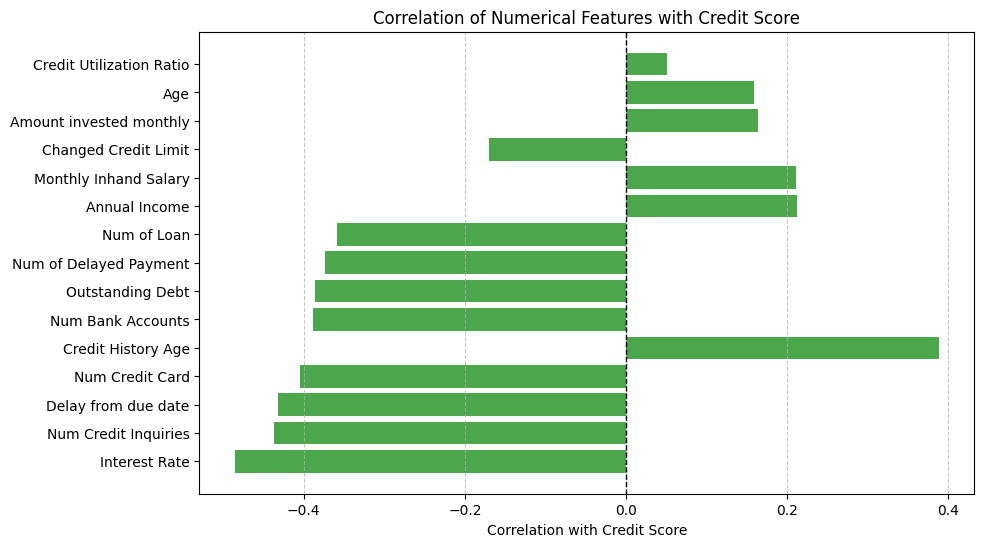

In [42]:
# Correlation with target variable
correlation_values = []
for col in numeric_features:
    correlation = clean_credit_card_df['Credit_Score'].corr(clean_credit_card_df[col])
    correlation_values.append((col, correlation))
correlation_values.sort(key=lambda x: abs(x[1]), reverse=True)

# Plot the correlation values
plt.figure(figsize=(10, 6))
plt.barh([str(x[0]).replace("_", " ") for x in correlation_values], [x[1] for x in correlation_values], color='green', alpha=0.7)
plt.xlabel('Correlation with Credit Score')
plt.title('Correlation of Numerical Features with Credit Score')
plt.axvline(0, color='black', lw=1, ls='--')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## 4) Data Processing

An insight that was particularly interesting was that the value "0" in the `Credit_Score` column was highly associated with older people and with individuals living in Zeroville. We wanted to further investigate this relationship, counting the number of individuals with a credit score of "0" in Zeroville or older than 55 and comparing it with the rest of the dataset. 

In [22]:
# Count how many times credit score is 0 and Age is greater than 55
age_60_credit_score_0 = clean_credit_card_df[(clean_credit_card_df['Age'] >= 55) & (clean_credit_card_df['Credit_Score'] == 0)].shape[0]
print(f"Number of customers with Credit Score 0 and Age > 55: {age_60_credit_score_0}")
# Count how many times credit score is 0 and Age is less than 55
age_below_60_credit_score_0 = clean_credit_card_df[(clean_credit_card_df['Age'] < 55) & (clean_credit_card_df['Credit_Score'] == 0)].shape[0]
print(f"Number of customers with Credit Score 0 and Age < 55: {age_below_60_credit_score_0}")

# Count how many times credit score is 0 per city
credit_score_0_per_city = clean_credit_card_df[clean_credit_card_df['Credit_Score'] == 0]['City'].value_counts()
print("Number of customers with Credit Score 0 per city:")
print(credit_score_0_per_city)

Number of customers with Credit Score 0 and Age > 55: 348
Number of customers with Credit Score 0 and Age < 55: 4
Number of customers with Credit Score 0 per city:
City
ZeroVille       338
Standhampton      9
Lonton            4
BadShire          1
Name: count, dtype: int64


Looking at the output, we see that there are 348 customers over the age of 55 and only 4 under 55 with a credit score of 0. This strong imbalance suggests that a score of 0 is not a legitimate credit score but rather a placeholder or result of missing data, especially among older individuals. Additionally, when we examine the distribution by city, we find that the vast majority of these cases (338 out of 352) come from a single city — ZeroVille — with only a handful in Standhampton, Lonton, and BadShire. This further reinforces the idea that these values are likely due to a systematic issue or data entry error specific to certain locations. Given that these 352 customers represent less than 0.5% of the total dataset, I will drop the rows with a credit score of 0 to avoid introducing noise or bias into the model, and to ensure the credit score feature remains meaningful.

In [23]:
# Drop the rows where Credit_Score is 0
clean_credit_card_df = clean_credit_card_df[clean_credit_card_df['Credit_Score'] != 0]

# Drop the rows in which the city is ZeroVille (probably a fake city name)
clean_credit_card_df = clean_credit_card_df[clean_credit_card_df['City'] != 'ZeroVille']

We also need to remove columns that are highly correlated to avoid multicollinearity. Specifically, we will drop the column `Monthly_Inhand_Salary` as it is highly correlated with `Annual_Income` (as expected).


In [24]:
# Drop the "Montly Inhand Salary" column
clean_credit_card_df.drop(columns=['Montly inhand Salary'], inplace=True, errors='ignore')

We also decided to drop the `City` column. It would be pointless to train the algorithm on a feature that is highly correlated with the target variable. The Bias is not only a problem for the model, but also for the individuals who are being classified. The model would be biased towards individuals from certain cities, which is not a fair or ethical approach to credit scoring. By removing this feature, we can ensure that the model is not biased towards any particular group of individuals and that it is making predictions based on relevant features only.

In [25]:
clean_credit_card_df.drop(columns=['City'], inplace=True, errors='ignore')

We now store the processed dataset in a csv file for future use. The dataset is now ready for modeling, and we can proceed with training and evaluating our machine learning model. We will also need to apply some preprocessing steps to the categorical features.

In [26]:
clean_credit_card_df.to_csv('Dataset/model_credit_card_data.csv', index=False)

In [ ]:
## Removing outliers from the dataset

def remove_outliers(df, column):
    """
    Remove outliers from a specified column in a DataFrame using the IQR method.
    
    Parameters:
      df: pandas DataFrame
      column: Column name from which to remove outliers
      
    Returns:
      A new DataFrame with outliers removed from the specified column.
    """
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 10 * IQR
    upper_bound = Q3 + 10 * IQR
    
    # Filter the DataFrame to remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(f"Shape of the DataFrame before removing outliers: {credit_card_df.shape}")

# Loop through each numerical feature and remove outliers
for col in numerical_features:
    cleaned_credit_card_df = remove_outliers(cleaned_credit_card_df, col)

# Display the shape of the DataFrame after removing outliers
print(f"Shape of the DataFrame after removing outliers: {cleaned_credit_card_df.shape}")